<center><h1>A data-driven approach for the assessment of the thermal stratification of reservoirs based on readily available data.</h1> 

<center><h4><span style='color:royalblue'> María Castrillo </span>, Fernando Aguilar, Daniel García
<center> (castrillo@ifca.unican.es)

In [1]:
#Import libraries and pack
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
import sklearn
import mlxtend
import tensorflow as tf
import shap
import scikeras

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
from scikeras.wrappers import KerasRegressor, KerasClassifier

In [3]:
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, SimpleRNN

In [4]:
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error

In [5]:
plt.rcParams["font.family"] = "serif"

In [6]:
tf.keras.utils.set_random_seed(42)

In [7]:
#Read the data
data = pd.read_csv("maxprofiles.csv", sep=";")
data["Date"] = pd.to_datetime(data["Date"])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         1688 non-null   int64         
 1   Date               1688 non-null   datetime64[ns]
 2   Depth              1688 non-null   float64       
 3   SampleLevel        1688 non-null   float64       
 4   Temp               1688 non-null   float64       
 5   pH                 1688 non-null   float64       
 6   Redox              1688 non-null   float64       
 7   Cond               1688 non-null   float64       
 8   OD                 1688 non-null   float64       
 9   Turb               1688 non-null   float64       
 10  Chl                1688 non-null   float64       
 11  Datetime           1688 non-null   object        
 12  Thermocline        1688 non-null   float64       
 13  Thermocline_depth  941 non-null    float64       
 14  Thermocl

In [9]:
data = data.drop(columns = ["Unnamed: 0", "Depth", "SampleLevel", "Turb", "Temp", "pH", "Redox", "Cond", "OD", "Chl"])

In [10]:
data.describe()

,Date,Thermocline,Thermocline_depth,Thermocline_temp,Gradient,AirTempMax,AirTempMin,AirTempAvg,Level,Wind,RadMax,RadAvg,Rain,Flow
count,1688,1688.000000,941.000000,941.000000,1676.000000,1686.000000,1686.000000,1686.000000,1688.000000,1686.000000,1671.000000,1671.000000,1674.000000,1688.000000
mean,2020-07-13 05:46:21.042653952,0.557464,12.471156,17.289691,0.519534,20.049193,8.515534,13.822960,613.694171,1.234193,366.434650,79.509928,1.246416,0.821594
min,2018-01-20 00:00:00,0.000000,2.012883,8.326815,-0.049997,-0.900000,-6.600000,-3.170000,604.610000,0.000000,0.000000,0.000000,0.000000,0.088000
25%,2019-04-13 18:00:00,0.000000,6.291062,14.737759,0.049247,13.300000,4.000000,8.190000,610.425000,1.000000,259.000000,39.505000,0.000000,0.190000
50%,2020-08-04 12:00:00,1.000000,8.441934,17.393472,0.398729,19.100000,8.150000,13.015000,614.540000,1.180000,389.000000,72.830000,0.000000,0.679500
75%,2021-10-10 06:00:00,1.000000,14.563156,20.054079,0.806763,27.100000,13.400000,19.610000,617.120000,1.420000,479.000000,117.405000,0.200000,1.272000
max,2022-12-22 00:00:00,1.000000,37.629839,24.808426,4.315071,41.700000,21.900000,32.270000,619.880000,3.820000,1353.000000,422.420000,88.500000,2.834000
std,NaN,0.496834,9.314165,3.187200,0.549628,8.586954,5.752663,7.046232,4.200454,0.406286,138.675878,45.946732,4.633908,0.677054


# Preprocessing

## Outliers

In [11]:
#After visual inspection we eliminate observations with RadMax > 800 and RadAvg < 180, which are obvious outliers in this time series.
data = data[data["RadMax"] < 800]
data = data[data["RadAvg"] < 180]

In [12]:
data.describe()

,Date,Thermocline,Thermocline_depth,Thermocline_temp,Gradient,AirTempMax,AirTempMin,AirTempAvg,Level,Wind,RadMax,RadAvg,Rain,Flow
count,1667,1667.000000,922.000000,922.000000,1655.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1655.000000,1667.000000
mean,2020-07-04 06:44:16.268746240,0.553089,12.255502,17.303777,0.519030,20.011362,8.492136,13.793311,613.790594,1.235573,364.749430,79.010312,1.255710,0.819040
min,2018-01-20 00:00:00,0.000000,2.012883,8.326815,-0.049997,-0.900000,-6.600000,-3.170000,604.760000,0.000000,0.000000,0.000000,0.000000,0.088000
25%,2019-04-08 12:00:00,0.000000,6.252587,14.678371,0.045907,13.300000,3.950000,8.110000,610.680000,1.000000,259.000000,39.395000,0.000000,0.190000
50%,2020-07-27 00:00:00,1.000000,8.314671,17.440326,0.394632,19.000000,8.100000,12.990000,614.600000,1.180000,389.000000,72.700000,0.000000,0.670000
75%,2021-09-26 12:00:00,1.000000,13.643029,20.077108,0.807797,27.100000,13.400000,19.665000,617.130000,1.430000,478.500000,116.890000,0.200000,1.272500
max,2022-12-22 00:00:00,1.000000,37.629839,24.808426,4.315071,41.700000,21.900000,32.270000,619.880000,3.820000,720.000000,175.850000,88.500000,2.834000
std,NaN,0.497323,9.266601,3.214957,0.552418,8.618713,5.776837,7.076304,4.127283,0.407969,133.328823,44.406074,4.656001,0.679128


## Violin plots

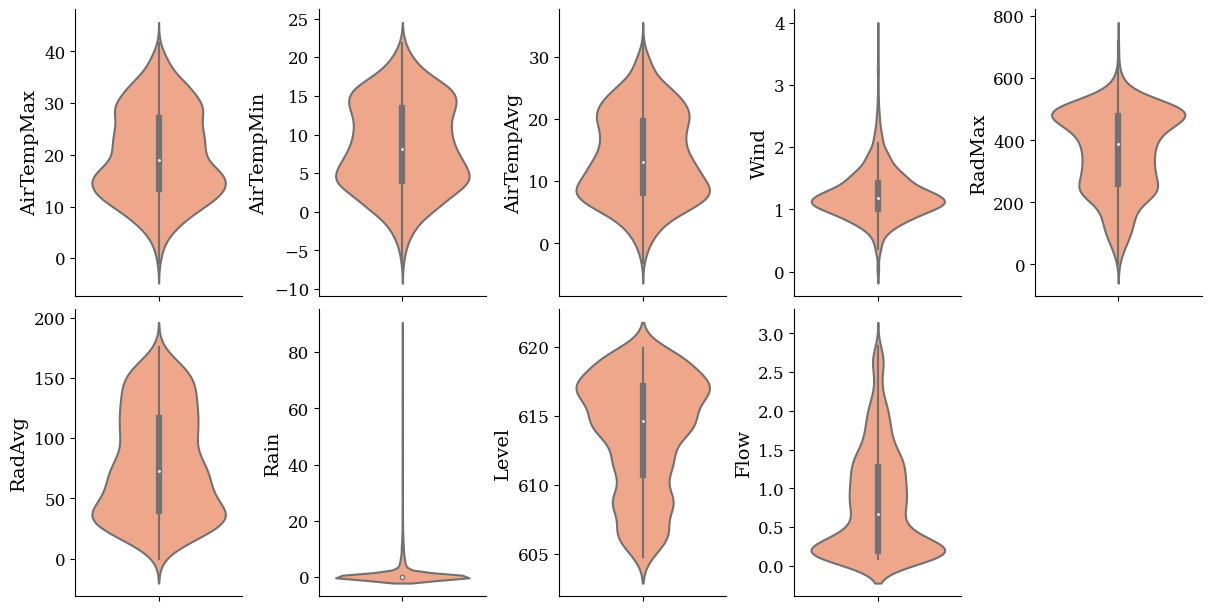

In [13]:
cols = ["AirTempMax", "AirTempMin", "AirTempAvg", "Wind", "RadMax", "RadAvg", "Rain", "Level", "Flow", "Flow"]

dark_gray = "#000000"
light_gray = "#eeeeee"

fig, axs = plt.subplots(2, 5, figsize=(12, 6), layout='constrained')

for i, col in enumerate(cols): 
    ax = axs.flat[i]
    sns.violinplot(y=data[col], ax=ax,  color="lightsalmon")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color(dark_gray)
    ax.spines["bottom"].set_color(dark_gray)
    ax.set_facecolor('xkcd:white')
    
    ax.get_yaxis().tick_left()
    ax.get_xaxis().tick_bottom()
    
    ax.tick_params(axis="both", which="major", labelsize=12, colors=dark_gray)
    ax.tick_params(axis="both", which="minor", labelsize=10, colors=dark_gray)
    ax.xaxis.label.set_color(dark_gray)
    ax.set_ylabel(cols[i], fontsize=14)
    
fig.delaxes(ax)

## Data shifts

In [14]:
data[["AirTempAvg1", "Wind1", "AirTempMin1", "AirTempMax1", "RadMax1", "RadAvg1", "Rain1", "Level1", "Flow1"]]=data[["AirTempAvg", "Wind", "AirTempMin", "AirTempMax", "RadMax", "RadAvg", "Rain", "Level", "Flow"]].shift(1, axis = 0)
data[["AirTempAvg2", "Wind2", "AirTempMin2", "AirTempMax2", "RadMax2", "RadAvg2", "Rain2", "Level2", "Flow2"]]=data[["AirTempAvg", "Wind", "AirTempMin", "AirTempMax", "RadMax", "RadAvg", "Rain", "Level", "Flow"]].shift(2, axis = 0)
data[["AirTempAvg3", "Wind3", "AirTempMin3", "AirTempMax3", "RadMax3", "RadAvg3", "Rain3", "Level3", "Flow3"]]=data[["AirTempAvg", "Wind", "AirTempMin", "AirTempMax", "RadMax", "RadAvg", "Rain", "Level", "Flow"]].shift(3, axis = 0)
data[["AirTempAvg4", "Wind4", "AirTempMin4", "AirTempMax4", "RadMax4", "RadAvg4", "Rain4", "Level4", "Flow4"]]=data[["AirTempAvg", "Wind", "AirTempMin", "AirTempMax", "RadMax", "RadAvg", "Rain", "Level", "Flow"]].shift(4, axis = 0)
data[["AirTempAvg5", "Wind5", "AirTempMin5", "AirTempMax5", "RadMax5", "RadAvg5", "Rain5", "Level5", "Flow5"]]=data[["AirTempAvg", "Wind", "AirTempMin", "AirTempMax", "RadMax", "RadAvg", "Rain", "Level", "Flow"]].shift(5, axis = 0)

# Modelling

## Unsupervised detection of the thermocline

In [15]:
#data["Date"]  = pd.to_datetime(data["Date"], format = "%Y-%M-%d").dt.normalize()
#Separate train and test fractions
data2 = data.drop(columns = ["Thermocline_depth", "Thermocline_temp"])
train = data2[data2["Date"] <= "2021-12-31"].dropna()
test = data2[data2["Date"] >= "2022-01-01"].dropna()

In [16]:
#Define inputs and target variable
X = train[["AirTempAvg", "Wind", "AirTempMin", "AirTempMax", "RadMax", "RadAvg", "Rain", "Level", "Flow"]]
y = train["Thermocline"]

In [17]:
#Scale the input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
#Define and train the model
kmeans = KMeans(n_clusters= 2, 
            random_state=42)

kmeans.fit(X_scaled)

#Predict the clusters
kmeans_pred = kmeans.predict(X_scaled)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [24]:
kmeans_pred = pd.DataFrame(kmeans_pred).set_index(y.index)

In [25]:
#Obtain clusters centers
kmeans.cluster_centers_

array([[-0.72860898, -0.11661967, -0.67534592, -0.72853517, -0.65189836,
        -0.68425177,  0.07913463, -0.11677786, -0.39218726],
       [ 0.9113829 ,  0.14587409,  0.84475864,  0.91129058,  0.81542917,
         0.85589854, -0.09898581,  0.14607196,  0.49056871]])

In [26]:
train = train.merge(kmeans_pred, left_index=True, right_index=True)
train = train.rename(columns = {'0_x':"kmeans"})

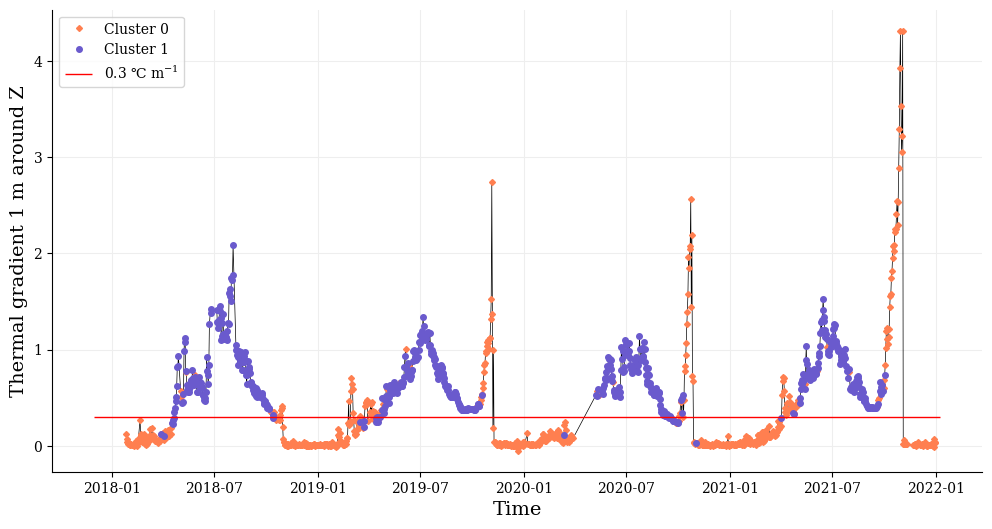

In [27]:
fig = plt.figure(figsize=(12,6))

plt.plot(train.Date, (train.Gradient), linewidth=0.5, color='black')
plt.plot(train.Date[train.kmeans==0], (train.Gradient[train.kmeans==0]), 
         linestyle=" ", marker="D", markersize=3, color='coral', label="Cluster 0")
plt.plot(train.Date[train.kmeans==1], (train.Gradient[train.kmeans==1]), 
         linestyle=" ", marker="o", markersize=4,  color='slateblue', label="Cluster 1")

plt.xlabel('Time', fontsize = 14)
plt.ylabel('Thermal gradient 1 m around Z', fontsize = 14)
plt.xticks(())
plt.yticks(np.arange(0,15,1))
plt.hlines(y=0.3, xmin=17500, xmax=19000, colors='red', linestyles='-', lw=1, label="0.3 \u2103 $\mathregular{m^{-1}}$")
plt.legend()

dark_gray = "#000000"
light_gray = "#eeeeee"

ax = fig.axes[0]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color(dark_gray)
ax.spines["bottom"].set_color(dark_gray)

ax.yaxis.grid(True, color=light_gray)
ax.xaxis.grid(True, color=light_gray)

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))

## Classification neural network

In [28]:
X_train = train[[
                 "AirTempAvg", "Wind", "AirTempMin", "AirTempMax", "RadMax", "RadAvg", "Rain", "Level", "Flow",
                 "AirTempAvg1", "Wind1", "AirTempMin1", "AirTempMax1", "RadMax1", "RadAvg1", "Rain1", "Level1", "Flow1",
                 "AirTempAvg2", "Wind2", "AirTempMin2", "AirTempMax2", "RadMax2", "RadAvg2", "Rain2", "Level2", "Flow2",
                 "AirTempAvg3", "Wind3", "AirTempMin3", "AirTempMax3", "RadMax3", "RadAvg3", "Rain3", "Level3", "Flow3",
                 "AirTempAvg4", "Wind4", "AirTempMin4", "AirTempMax4", "RadMax4", "RadAvg4", "Rain4", "Level4", "Flow4",
                 "AirTempAvg5", "Wind5", "AirTempMin5", "AirTempMax5", "RadMax5", "RadAvg5", "Rain5", "Level5", "Flow5",
                ]]
y_train = train["Thermocline"]
X_test = test[[        
                 "AirTempAvg", "Wind", "AirTempMin", "AirTempMax", "RadMax", "RadAvg", "Rain",  "Level", "Flow",
                 "AirTempAvg1", "Wind1", "AirTempMin1", "AirTempMax1", "RadMax1", "RadAvg1", "Rain1", "Level1", "Flow1", 
                 "AirTempAvg2", "Wind2", "AirTempMin2", "AirTempMax2", "RadMax2", "RadAvg2", "Rain2", "Level2", "Flow2",
                 "AirTempAvg3", "Wind3", "AirTempMin3", "AirTempMax3", "RadMax3", "RadAvg3", "Rain3", "Level3", "Flow3",
                 "AirTempAvg4", "Wind4", "AirTempMin4", "AirTempMax4", "RadMax4", "RadAvg4", "Rain4", "Level4", "Flow4",
                 "AirTempAvg5", "Wind5", "AirTempMin5", "AirTempMax5", "RadMax5", "RadAvg5", "Rain5", "Level5", "Flow5",
              ]]
y_test = test["Thermocline"]

In [ ]:
#Scaling
scaler = StandardScaler()

X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

In [ ]:
#Define the architecture of the NN
NN_class = Sequential([
    Dense(32, input_shape=(len(X_train.columns),)),
    Activation('relu'),
     Dropout(0.2),
    Dense(16),
    Activation("relu"),
    Dropout(0.2),
    Dense(1), 
    Activation('sigmoid'),
])

### Cassification neural network with cross-validation

In [ ]:
#Compile the NN
metric = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

opt = keras.optimizers.Adam(learning_rate=0.0001)

NN_class.compile(loss = "binary_crossentropy",
                optimizer = opt, 
                metrics=metric)

In [ ]:
model = KerasClassifier(NN_class, batch_size=32, verbose=1, epochs=500)

In [ ]:
scoring = {'acc': 'accuracy',
           'recall': 'recall',
           'auc': 'roc_auc'}

In [ ]:
kfold = KFold(n_splits=4, shuffle=False)
results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)

In [ ]:
#Cross-validation results
results

In [ ]:
#Averaged results
print("Accuracy: " + str(np.mean(results["test_acc"])))
print("Recall: " + str(np.mean(results["test_recall"])))
print("AUC: " + str(np.mean(results["test_auc"])))

### Cassification neural network without cross-validation

In [ ]:
#Compile the NN
metric = tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

opt = keras.optimizers.Adam(learning_rate=0.0001)

NN_class.compile(loss = "binary_crossentropy",
                optimizer = opt, 
                metrics=metric)

In [ ]:
#Train the NN with validation split
log_class = NN_class.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.25)

In [ ]:
#Plot the train accuracy and validation accuracy
plt.plot(log_class.history['binary_accuracy'])
plt.plot(log_class.history['val_binary_accuracy'])
plt.legend(['accuracy','validation accuracy'])

In [ ]:
NN_class.fit(X_train, y_train, epochs=200, batch_size=32)

In [ ]:
scores = NN_class.evaluate(X_train, y_train)
print("%s: %.2f%%" % (NN_class.metrics_names[1], scores[1]*100))

In [ ]:
scores = NN_class.evaluate(X_test, y_test)
print("%s: %.2f%%" % (NN_class.metrics_names[1], scores[1]*100))

In [ ]:
y_pred_train = NN_class.predict(X_train)
y_pred = NN_class.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8,6))
cm_train = confusion_matrix(y_train, y_pred_train.round())  #target and predictions
display = ConfusionMatrixDisplay(cm_train)
ax.set(title='Train Confusion Matrix')
display.plot(ax=ax)

fig, ax = plt.subplots(figsize=(8,6))
cm_test = confusion_matrix(y_test, y_pred.round())
display = ConfusionMatrixDisplay(cm_test)
ax.set(title='Test Confusion Matrix')
display.plot(ax=ax)

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_train, y_pred_train)
RocCurveDisplay.from_predictions(y_test, y_pred)

In [ ]:
from sklearn.metrics import recall_score

recall_train = recall_score(y_train, y_pred_train.round())
recall_test = recall_score(y_test, y_pred.round())

print(recall_train)
print(recall_test)

In [ ]:
y_pred_train = pd.Series(np.array(y_pred_train.round(0).reshape(-1-1)))
y_pred_train.index = y_train.index

In [ ]:
y_pred = pd.Series(np.array(y_pred.round(0).reshape(-1-1)))
y_pred.index = y_test.index

In [ ]:
yy_train = pd.concat((data["Date"], y_train), axis=1).set_index("Date", drop=True)
yy_pred_train = pd.concat((data["Date"], y_pred_train), axis=1).set_index("Date", drop=True)
yy_test = pd.concat((data["Date"], y_test), axis=1).set_index("Date", drop=True)
yy_pred = pd.concat((data["Date"], y_pred), axis=1).set_index("Date", drop=True)

In [ ]:
fig = plt.figure(figsize=(12,3))

plt.plot(yy_train+0.05, linewidth=0.0, marker = "o", markersize = 7, color="darkslateblue")
plt.plot(yy_test+0.05, linewidth=0.0, marker = "o", markersize = 7,label="Real data", color="darkslateblue")
plt.plot(yy_pred_train-0.05, linewidth=0.0, marker = "o", markersize = 7,  color="lightsalmon")
plt.plot(yy_pred-0.05, linewidth=0.0, marker = "o", markersize = 7, label="Predicted data", color="lightsalmon")

plt.axvline(x = 18994, color = 'black', ls='--', lw=1)

plt.xlabel("Date", fontsize = 14)
plt.ylabel("Thermocline presence", fontsize = 14)
plt.legend(loc="center left", facecolor="white")

dark_gray = "#000000"
light_gray = "#eeeeee"

ax = fig.axes[0]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color(dark_gray)
ax.spines["bottom"].set_color(dark_gray)

ax.set_facecolor('xkcd:white')

ax.get_yaxis().tick_left()
ax.get_xaxis().tick_bottom()

ax.tick_params(axis="both", which="major", labelsize=10, colors=dark_gray)
ax.tick_params(axis="both", which="minor", labelsize=8, colors=dark_gray)
ax.xaxis.label.set_color(dark_gray)
ax.yaxis.label.set_color(dark_gray)

ax.set_yticks((0,1))

ax.yaxis.grid(True, color=light_gray, lw=20)
ax.xaxis.grid(True, color=light_gray)

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))

## Regression neural network

In [29]:
train = data[data["Date"] <= "2021-12-31"].dropna()
test = data[data["Date"] >= "2022-01-01"].dropna()

In [30]:
X_train = train[[
                "AirTempAvg", "Wind", "AirTempMin", "AirTempMax", "RadMax", "RadAvg", "Rain", "Level", "Flow",
                "AirTempAvg1", "Wind1", "AirTempMin1", "AirTempMax1", "RadMax1", "RadAvg1", "Rain1", "Level1", "Flow1",
                "AirTempAvg2", "Wind2", "AirTempMin2", "AirTempMax2", "RadMax2", "RadAvg2", "Rain2", "Level2", "Flow2",
                "AirTempAvg3", "Wind3", "AirTempMin3", "AirTempMax3", "RadMax3", "RadAvg3", "Rain3", "Level3", "Flow3",
                "AirTempAvg4", "Wind4", "AirTempMin4", "AirTempMax4", "RadMax4", "RadAvg4", "Rain4", "Level4", "Flow4",
                "AirTempAvg5", "Wind5", "AirTempMin5", "AirTempMax5", "RadMax5", "RadAvg5", "Rain5", "Level5", "Flow5",
                ]]
y_train = train["Thermocline_depth"]
X_test = test[[             
                "AirTempAvg", "Wind", "AirTempMin", "AirTempMax", "RadMax", "RadAvg", "Rain",  "Level", "Flow",
                "AirTempAvg1", "Wind1", "AirTempMin1", "AirTempMax1", "RadMax1", "RadAvg1", "Rain1", "Level1", "Flow1", 
                "AirTempAvg2", "Wind2", "AirTempMin2", "AirTempMax2", "RadMax2", "RadAvg2", "Rain2", "Level2", "Flow2",
                "AirTempAvg3", "Wind3", "AirTempMin3", "AirTempMax3", "RadMax3", "RadAvg3", "Rain3", "Level3", "Flow3",
                "AirTempAvg4", "Wind4", "AirTempMin4", "AirTempMax4", "RadMax4", "RadAvg4", "Rain4", "Level4", "Flow4",
                "AirTempAvg5", "Wind5", "AirTempMin5", "AirTempMax5", "RadMax5", "RadAvg5", "Rain5", "Level5", "Flow5",
              ]]
y_test = test["Thermocline_depth"]

In [31]:
# Scaling
scaler = StandardScaler()

X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
#Define the architecture of the NN
NN_regr = Sequential([
    Dense(32, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dropout(0.4),
    Dense(16),
    Activation('relu'),
    Dropout(0.2),
    Dense(8),
    Activation('relu'),
    Dense(1), 
])

### Regression neural network with cross-validation

In [33]:
#Compile
opt = keras.optimizers.Adam(learning_rate=0.001)

NN_regr.compile(loss= "mae",
                optimizer=opt, 
                metrics= "mae")

In [34]:
model = KerasRegressor(NN_regr, batch_size=32, verbose=1, epochs=500)

In [ ]:
kfold = KFold(n_splits=4, shuffle=False)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')

INFO:tensorflow:Assets written to: C:\Users\Maria\AppData\Local\Temp\tmp_y5xklv8\assets


INFO:tensorflow:Assets written to: C:\Users\Maria\AppData\Local\Temp\tmp_y5xklv8\assets


Epoch 1/500



18/18 [==============================] - 1s 2ms/step - loss: 12.2366 - mae: 12.2366
Epoch 2/500
18/18 [==============================] - 0s 924us/step - loss: 10.9267 - mae: 10.9267
Epoch 3/500
18/18 [==============================] - 0s 2ms/step - loss: 8.7743 - mae: 8.7743
Epoch 4/500
18/18 [==============================] - 0s 919us/step - loss: 7.3026 - mae: 7.3026
Epoch 5/500
18/18 [==============================] - 0s 918us/step - loss: 5.8122 - mae: 5.8122
Epoch 6/500
18/18 [==============================] - 0s 919us/step - loss: 5.4861 - mae: 5.4861
Epoch 7/500
18/18 [==============================] - 0s 919us/step - loss: 5.0256 - mae: 5.0256
Epoch 8/500
18/18 [==============================] - 0s 924us/step - loss: 4.5066 - mae: 4.5066
Epoch 9/500
18/18 [==============================] - 0s 914us/step - loss: 4.3497 - mae: 4.3497
Epoch 10/500
18/18 [==============================] - 0s 383us/step - loss: 4.1346 - mae: 4.1346
Epoch 11/500
18/18 [==============================]

In [ ]:
#Cross-validation results
results

In [ ]:
#Averaged results
np.mean(abs(results))

### Regression neural network without cross-validation

In [ ]:
#Compile
opt = keras.optimizers.Adam(learning_rate=0.001)

NN_regr.compile(loss= "mae",
                optimizer=opt, 
                metrics= "mae")

In [ ]:
#Train the NN with validation split
log_rgr = NN_regr.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.25)

In [ ]:
#Plot the train accuracy and validation accuracy
plt.plot(log_rgr.history['mae'])
plt.plot(log_rgr.history['val_mae'])
plt.legend(['mae','validation mae'])

In [ ]:
NN_regr.fit(X_train, y_train, epochs=500, batch_size=32)

In [ ]:
scores = NN_regr.evaluate(X_train, y_train)
print("%s: %.2f" % (NN_regr.metrics_names[1], scores[1]))

In [ ]:
scores = NN_regr.evaluate(X_test, y_test)
print("%s: %.2f" % (NN_regr.metrics_names[1], scores[1]))

In [ ]:
y_pred_train = NN_regr.predict(X_train)
y_pred = NN_regr.predict(X_test)

In [ ]:
y_pred = pd.Series(np.array(y_pred.reshape(-1-1)))
y_pred.index = y_test.index

In [ ]:
y_pred_train = pd.Series(np.array(y_pred_train.reshape(-1-1)))
y_pred_train.index = y_train.index

In [ ]:
MAE_train = np.mean(np.abs((y_train-y_pred_train)))
MAE_test = np.mean(np.abs((y_test-y_pred)))
P50_train = np.quantile(np.abs(y_train-y_pred_train), 0.50)
P50_test = np.quantile(np.abs(y_test-y_pred), 0.50)
print("P50_train: " + str(P50_train))
print("P50_test: " + str(P50_test))
print("MAE_train percentile: " + str((np.sum(np.abs(y_train-y_pred_train) < MAE_train) / len(y_train-y_pred_train) * 100).round(2)))
print("MAE_test percentile: " + str((np.sum(np.abs(y_test-y_pred) < MAE_test) / len(y_test-y_pred) * 100).round(2)))

In [ ]:
print("MAE_test percentile: " + str((np.sum(np.abs(y_test-y_pred) < MAE_test) / len(y_test-y_pred) * 100).round(2)))

In [ ]:
dates_train = data["Date"].iloc[y_train.index]
dates_test = data["Date"].iloc[y_test.index]

In [ ]:
y_pred_high_error = y_pred[abs(y_pred-y_test) > scores[1]]
y_pred_low_error = y_pred[abs(y_pred-y_test) <= scores[1]]

In [ ]:
yy_train = pd.concat((data["Date"], y_train), axis=1).set_index("Date", drop=True)
yy_pred_train = pd.concat((data["Date"], y_pred_train), axis=1).set_index("Date", drop=True)
yy_test = pd.concat((data["Date"], y_test), axis=1).set_index("Date", drop=True)
yy_pred_high_error = pd.concat((data["Date"], y_pred_high_error), axis=1).set_index("Date", drop=True)
yy_pred_low_error = pd.concat((data["Date"], y_pred_low_error), axis=1).set_index("Date", drop=True)

In [ ]:
fig = plt.figure(figsize=(12,6))

plt.plot(data["Thermocline_depth"], linewidth=0, marker = "o", markersize = 5, label="Real data", color="darkslateblue")
plt.plot(y_pred_train, linewidth=0, marker = "^", markersize = 6, label="Predicted data (train)", color="#f57d6b", markeredgecolor="darksalmon")
plt.plot(y_pred_high_error, linewidth=0, marker = "^", markersize = 6, label="Predicted data (test-high)", color="#ffb14e", markeredgecolor="orange")
plt.plot(y_pred_low_error, linewidth=0, marker = "^", markersize = 6, label="Predicted data (test-low)", color="#ffff52", markeredgecolor="gold")

plt.xlabel("Date", fontsize = 14)
plt.ylabel("Z (m)", fontsize = 14)
plt.legend(loc="upper left", facecolor="white")

dark_gray = "#000000"
light_gray = "#eeeeee"

ax = fig.axes[0]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color(dark_gray)
ax.spines["bottom"].set_color(dark_gray)

ax.set_facecolor('xkcd:white')

ax.get_yaxis().tick_left()
ax.get_xaxis().tick_bottom()

ax.tick_params(axis="both", which="major", labelsize=10, colors=dark_gray)
ax.tick_params(axis="both", which="minor", labelsize=8, colors=dark_gray)
ax.xaxis.label.set_color(dark_gray)
ax.yaxis.label.set_color(dark_gray)

ax.yaxis.grid(True, color=light_gray)
ax.xaxis.grid(True, color=light_gray)

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))


In [ ]:
fig = plt.figure(figsize=(12,6))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(data["Thermocline_depth"], linewidth=0, marker = "o", markersize = 3, label="Real data (train)", color="darkslateblue")
ax2.plot(data["Level"], linewidth=0, marker = "o", markersize = 3, label="Level", color="red")

## SHAP values

In [ ]:
# Fits the explainer
explainer = shap.Explainer(NN_regr.predict, X_train)

# Calculates the SHAP values 
shap_values = explainer(X_test)

In [ ]:
# Summarize the effects of features
shap.plots.beeswarm(shap_values, color=plt.get_cmap("plasma"))

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
abs(shap_values.values).mean(axis=0)